### Facial Landmark Extraction using MediaPipe
This code processes grayscale facial images from the FER2013 dataset and extracts 136 facial landmark features using MediaPipe Face Mesh. These features are saved into a structured CSV file for use in emotion recognition models.

In [2]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
from tqdm import tqdm

# Load FER2013 CSV
df = pd.read_csv("fer2013_combined.csv")

# Prepare MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# Function to extract 136 facial landmark features
def extract_landmarks(img_array):
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    results = face_mesh.process(img_rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]
        coords = []
        for lm in landmarks.landmark[:68]:  # use first 68 for compatibility
            coords.append(lm.x)
            coords.append(lm.y)
        return coords
    else:
        return None

# Process all images
landmark_features = []
skipped = 0

for pixels in tqdm(df['pixels']):
    img = np.fromstring(pixels, dtype=np.uint8, sep=' ').reshape(48, 48)
    img = cv2.resize(img, (192, 192))  # upscale for better detection
    coords = extract_landmarks(img)
    if coords:
        landmark_features.append(coords)
    else:
        landmark_features.append([0.0] * 136)  # fallback if no face detected
        skipped += 1

print(f"Skipped {skipped} images with no face detected.")

# Optional: add demographics if you have them (e.g., age, gender)
# For now, just use landmark features
landmarks_df = pd.DataFrame(landmark_features)
landmarks_df.to_csv("structured_features.csv", index=False)


100%|██████████| 35887/35887 [04:59<00:00, 119.81it/s]


Skipped 3007 images with no face detected.


### Adding Demographic Features to Structured Facial Data
This section enriches the facial landmark dataset by adding simulated demographic attributes such as age, gender, and head pose. These features can help improve model performance for tasks like emotion recognition, especially when personal and contextual differences matter.

In [4]:
import pandas as pd
import numpy as np

# Load your structured features (landmarks)
landmarks_df = pd.read_csv("structured_features.csv")

# You should replace these with real data
age = np.random.randint(10, 60, size=len(landmarks_df))  # Example: Random ages
gender = np.random.randint(0, 2, size=len(landmarks_df))  # 0 for female, 1 for male
head_pose = np.random.uniform(-45, 45, size=len(landmarks_df))  # Example: Random head pose

# Combine landmarks with demographic data (age, gender, head_pose)
landmarks_df['age'] = age
landmarks_df['gender'] = gender
landmarks_df['head_pose'] = head_pose

# Now save the updated structured features
landmarks_df.to_csv("structured_features_with_demographics.csv", index=False)


### Multi-Input Emotion Recognition Model Using FER-2013 and Structured Features
This script builds and trains a deep learning model that combines facial image data from the FER-2013 dataset with additional structured features (facial landmarks + demographics) to improve the accuracy of emotion classification.

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# -----------------------
# STEP 1: LOAD THE DATA
# -----------------------

# Load FER-2013 images (preprocessed)
df = pd.read_csv("fer2013_combined.csv")

# Convert image strings to numpy arrays
X_image = np.array([np.fromstring(pixels, dtype=np.uint8, sep=' ').reshape(48, 48, 1)
                    for pixels in df["pixels"]])
X_image = X_image / 255.0  # Normalize pixel values

# Encode emotion labels
y = to_categorical(df["emotion"], num_classes=7)

# ------------------------------
# STEP 2: LOAD STRUCTURED INPUT
# ------------------------------

# Assuming landmarks + demographics are saved in a separate file
structured_df = pd.read_csv("structured_features_with_demographics.csv")  # 136 landmarks + 3 demographics (e.g., age, gender, head_pose)
X_struct = structured_df.values.astype('float32')  # shape: (n_samples, 139)

# --------------------------------
# STEP 3: SPLIT TRAIN/VALIDATION
# --------------------------------

X_img_train, X_img_val, X_struct_train, X_struct_val, y_train, y_val = train_test_split(
    X_image, X_struct, y, test_size=0.2, random_state=42
)

# ---------------------------
# STEP 4: DEFINE THE MODEL
# ---------------------------

# CNN branch (image input)
img_input = Input(shape=(48, 48, 1), name='image_input')
x = Conv2D(64, (3, 3), activation='relu')(img_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

# Landmark + demographics branch (structured input)
structured_input = Input(shape=(139,), name='structured_input')
y = Dense(128, activation='relu')(structured_input)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

# Merge branches
combined = concatenate([x, y])
z = Dense(256, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(7, activation='softmax')(z)

# Final model
model = Model(inputs=[img_input, structured_input], outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -----------------------
# STEP 5: TRAIN THE MODEL
# -----------------------

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit model
model.fit(
    [X_img_train, X_struct_train], y_train,
    validation_data=([X_img_val, X_struct_val], y_val),
    epochs=30,
    batch_size=64,
    callbacks=[lr_scheduler, early_stopping]
)

# ------------------------
# STEP 6: SAVE & EVALUATE
# ------------------------

model.save("multi_input_emotion_model.h5")
val_loss, val_acc = model.evaluate([X_img_val, X_struct_val], y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/30
449/449 [==============================] - 203s 445ms/step - loss: 1.8331 - accuracy: 0.2722 - val_loss: 1.7512 - val_accuracy: 0.2655 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - 205s 458ms/step - loss: 1.6185 - accuracy: 0.3532 - val_loss: 1.5836 - val_accuracy: 0.3803 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - 208s 463ms/step - loss: 1.5343 - accuracy: 0.3952 - val_loss: 1.5237 - val_accuracy: 0.4252 - lr: 0.0010
Epoch 4/30
449/449 [==============================] - 201s 448ms/step - loss: 1.4633 - accuracy: 0.4291 - val_loss: 1.4188 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 5/30
449/449 [==============================] - 207s 461ms/step - loss: 1.4260 - accuracy: 0.4429 - val_loss: 1.3595 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 6/30
449/449 [==============================] - 218s 485ms/step - loss: 1.3839 - accuracy: 0.4618 - val_loss: 1.3155 - val_accuracy: 0.4972 - lr: 0.0010
Epoch 7/30
449/449 [==========================

### Enhanced Multi-Input Emotion Recognition Model (FER-2013 + Structured Features) THE PREFEERED AND USED MODEL
This version improves the model by incorporating data augmentation, deeper CNN architecture, and Global Average Pooling, making it more robust and generalizable.

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------
# STEP 1: LOAD THE DATA
# -----------------------

df = pd.read_csv("fer2013_combined.csv")
X_image = np.array([np.fromstring(pixels, dtype=np.uint8, sep=' ').reshape(48, 48, 1)
                    for pixels in df["pixels"]])
X_image = X_image / 255.0

y = to_categorical(df["emotion"], num_classes=7)

# ------------------------------
# STEP 2: LOAD STRUCTURED INPUT
# ------------------------------

structured_df = pd.read_csv("structured_features_with_demographics.csv")
X_struct = structured_df.values.astype('float32')

# --------------------------------
# STEP 3: SPLIT TRAIN/VALIDATION
# --------------------------------

X_img_train, X_img_val, X_struct_train, X_struct_val, y_train, y_val = train_test_split(
    X_image, X_struct, y, test_size=0.2, random_state=42
)

# ---------------------------
# STEP 4: DATA AUGMENTATION
# ---------------------------

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_img_train)

# ---------------------------
# STEP 5: DEFINE THE MODEL
# ---------------------------

img_input = Input(shape=(48, 48, 1), name='image_input')
x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

structured_input = Input(shape=(139,), name='structured_input')
y = Dense(128, activation='relu')(structured_input)
y = Dropout(0.2)(y)
y = Dense(64, activation='relu')(y)

combined = concatenate([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(7, activation='softmax')(z)

model = Model(inputs=[img_input, structured_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -----------------------
# STEP 6: TRAIN THE MODEL
# -----------------------

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    datagen.flow([X_img_train, X_struct_train], y_train, batch_size=64),
    validation_data=([X_img_val, X_struct_val], y_val),
    epochs=50,
    callbacks=[lr_scheduler, early_stopping]
)

# ------------------------
# STEP 7: SAVE & EVALUATE
# ------------------------

model.save("multi_input_emotion_model.h5")
val_loss, val_acc = model.evaluate([X_img_val, X_struct_val], y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/50
449/449 [==============================] - 640s 1s/step - loss: 1.7958 - accuracy: 0.2760 - val_loss: 2.0077 - val_accuracy: 0.2244 - lr: 0.0010
Epoch 2/50
449/449 [==============================] - 634s 1s/step - loss: 1.4903 - accuracy: 0.4253 - val_loss: 1.6842 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 613s 1s/step - loss: 1.3108 - accuracy: 0.5048 - val_loss: 1.4114 - val_accuracy: 0.4537 - lr: 0.0010
Epoch 4/50
449/449 [==============================] - 627s 1s/step - loss: 1.2230 - accuracy: 0.5386 - val_loss: 1.2719 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 5/50
449/449 [==============================] - 611s 1s/step - loss: 1.1686 - accuracy: 0.5559 - val_loss: 1.2060 - val_accuracy: 0.5446 - lr: 0.0010
Epoch 6/50
449/449 [==============================] - 620s 1s/step - loss: 1.1333 - accuracy: 0.5729 - val_loss: 1.1505 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 7/50
449/449 [==============================] - 623s 1s/st

68 PERCENT ACCURACY ACHIEVED

### Multi-Input Emotion Recognition Model Using MobileNetV2 and Structured Features 
This code builds a multi-input emotion recognition model using MobileNetV2 for facial image features and dense layers for structured data like landmarks and demographics. It includes data augmentation, training with early stopping, and fine-tuning for improved accuracy. The final model is saved and evaluated on a validation set.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------
# STEP 1: LOAD THE DATA
# -----------------------
df = pd.read_csv("fer2013_combined.csv")
X_image = np.array([np.fromstring(pixels, dtype=np.uint8, sep=' ').reshape(48, 48, 1)
                    for pixels in df["pixels"]])
X_image = X_image / 255.0
X_image_rgb = np.repeat(X_image, 3, axis=-1)  # Grayscale to RGB

y = to_categorical(df["emotion"], num_classes=7)

# ------------------------------
# STEP 2: LOAD STRUCTURED INPUT
# ------------------------------
structured_df = pd.read_csv("structured_features_with_demographics.csv")
X_struct = structured_df.values.astype('float32')

# ------------------------------
# STEP 3: SPLIT DATA
# ------------------------------
X_img_train, X_img_val, X_struct_train, X_struct_val, y_train, y_val = train_test_split(
    X_image_rgb, X_struct, y, test_size=0.2, random_state=42
)

# ---------------------------
# STEP 4: AUGMENTATION
# ---------------------------
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_img_train)

# ---------------------------
# STEP 5: CUSTOM DATA GENERATOR
# ---------------------------
class MultiInputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, structs, labels, batch_size, datagen):
        self.images = images
        self.structs = structs
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_structs = self.structs[batch_indices]
        batch_labels = self.labels[batch_indices]
        augmented_images = np.array([self.datagen.random_transform(img) for img in batch_images])
        return [augmented_images, batch_structs], batch_labels

train_generator = MultiInputDataGenerator(X_img_train, X_struct_train, y_train, batch_size=64, datagen=datagen)

# ---------------------------
# STEP 6: DEFINE THE MODEL
# ---------------------------
# Image branch
img_input = Input(shape=(48, 48, 3), name='image_input')
base_model = MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model(img_input, training=False)
x = GlobalAveragePooling2D()(x)

# Structured input
structured_input = Input(shape=(139,), name='structured_input')
y_struct = Dense(128, activation='relu')(structured_input)
y_struct = Dropout(0.3)(y_struct)
y_struct = Dense(64, activation='relu')(y_struct)

# Combine
combined = concatenate([x, y_struct])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(7, activation='softmax')(z)

model = Model(inputs=[img_input, structured_input], outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# ---------------------------
# STEP 7: INITIAL TRAINING
# ---------------------------
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=([X_img_val, X_struct_val], y_val),
    epochs=50,
    callbacks=[lr_scheduler, early_stopping]
)

# ---------------------------
# STEP 8: FINE-TUNE MODEL
# ---------------------------
print("\n🔧 Fine-tuning MobileNetV2 base...\n")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_generator,
    validation_data=([X_img_val, X_struct_val], y_val),
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

# ---------------------------
# STEP 9: SAVE & EVALUATE
# ---------------------------
model.save("mobilenetv2_multi_input_finetuned_model.h5")
val_loss, val_acc = model.evaluate([X_img_val, X_struct_val], y_val)
print(f"\n✅ Final Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/50
449/449 [==============================] - 114s 237ms/step - loss: 1.8278 - accuracy: 0.2816 - val_loss: 1.7217 - val_accuracy: 0.3199 - lr: 0.0010
Epoch 2/50
449/449 [==============================] - 98s 217ms/step - loss: 1.7611 - accuracy: 0.3134 - val_loss: 1.6982 - val_accuracy: 0.3396 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 96s 213ms/step - loss: 1.7383 - accuracy: 0.3316 - val_loss: 1.6895 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 4/50
449/449 [==============================] - 96s 214ms/step - loss: 1.7279 - accuracy: 0.3374 - val_loss: 1.6730 - val_accuracy: 0.3682 - lr: 0.0010
Epoch 5/50
449/449 [==============================] - 101s 224ms/step - loss: 1.7183 - accuracy: 0.3457 - val_loss: 1.6766 - val_accuracy: 0.3598 - lr: 0.0010
Epoch 6/50
449/449 [==============================] - 99s 220ms/step - loss: 1.7103 - accuracy: 0.3489 - val_loss: 1.6710 - val_accuracy: 0.3605 - lr: 0.0010
Epoch 7/50
449/449 [==============================

### Fine-Tuned Multi-Input Emotion Recognition with Resized RGB Images and Structured Features
This model combines 96×96 RGB facial images and structured data (e.g., landmarks, demographics) using MobileNetV2 and dense layers. It applies augmentation, transfer learning, and fine-tuning to improve classification accuracy and saves the final trained model for evaluation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------
# STEP 1: LOAD THE DATA
# -----------------------
df = pd.read_csv("fer2013_combined.csv")

# Convert grayscale pixels to RGB format
X_image = np.array([np.fromstring(pixels, dtype=np.uint8, sep=' ').reshape(48, 48, 1)
                    for pixels in df["pixels"]])
X_image = np.repeat(X_image, 3, axis=-1)  # Convert grayscale to RGB (3 channels)

# Memory-efficient resizing & preprocessing
def resize_and_preprocess(images, target_size=(96, 96)):
    resized = []
    for img in images:
        img = tf.image.resize(img, target_size)
        img = preprocess_input(img)
        resized.append(img)
    resized = np.stack(resized)
    gc.collect()
    return resized

X_image = resize_and_preprocess(X_image)

y = to_categorical(df["emotion"], num_classes=7)

# ------------------------------
# STEP 2: LOAD STRUCTURED INPUT
# ------------------------------
structured_df = pd.read_csv("structured_features_with_demographics.csv")
X_struct = structured_df.values.astype('float32')

# --------------------------------
# STEP 3: SPLIT TRAIN/VALIDATION
# --------------------------------
X_img_train, X_img_val, X_struct_train, X_struct_val, y_train, y_val = train_test_split(
    X_image, X_struct, y, test_size=0.2, random_state=42
)

# ---------------------------
# STEP 4: DATA AUGMENTATION
# ---------------------------
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_img_train)

# ---------------------------
# STEP 5: DEFINE THE MODEL
# ---------------------------
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

img_input = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Structured input branch
structured_input = Input(shape=(X_struct.shape[1],), name='structured_input')
y = Dense(128, activation='relu')(structured_input)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

# Combine branches
combined = concatenate([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(7, activation='softmax')(z)

model = Model(inputs=[img_input, structured_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -----------------------
# STEP 6: TRAIN THE MODEL
# -----------------------
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    datagen.flow([X_img_train, X_struct_train], y_train, batch_size=32),
    validation_data=([X_img_val, X_struct_val], y_val),
    epochs=30,
    callbacks=[lr_scheduler, early_stopping]
)

# ------------------------
# STEP 7: FINE-TUNING
# ------------------------
# Unfreeze some base_model layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    datagen.flow([X_img_train, X_struct_train], y_train, batch_size=32),
    validation_data=([X_img_val, X_struct_val], y_val),
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

# ------------------------
# STEP 8: SAVE & EVALUATE
# ------------------------
model.save("finetuned_multi_input_mobilenet_model.h5")
val_loss, val_acc = model.evaluate([X_img_val, X_struct_val], y_val)
print(f"✅ Final Validation Accuracy: {val_acc * 100:.2f}%")


9406464/9406464 [==============================] - 6s 1us/step
Epoch 1/30
898/898 [==============================] - 232s 254ms/step - loss: 1.6832 - accuracy: 0.3335 - val_loss: 1.5324 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 2/30
898/898 [==============================] - 248s 276ms/step - loss: 1.5745 - accuracy: 0.3829 - val_loss: 1.4682 - val_accuracy: 0.4407 - lr: 0.0010
Epoch 3/30
898/898 [==============================] - 242s 269ms/step - loss: 1.5420 - accuracy: 0.3989 - val_loss: 1.4657 - val_accuracy: 0.4455 - lr: 0.0010
Epoch 4/30
898/898 [==============================] - 257s 286ms/step - loss: 1.5228 - accuracy: 0.4113 - val_loss: 1.4495 - val_accuracy: 0.4451 - lr: 0.0010
Epoch 5/30
898/898 [==============================] - 235s 262ms/step - loss: 1.5089 - accuracy: 0.4150 - val_loss: 1.4435 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 6/30
898/898 [==============================] - 253s 282ms/step - loss: 1.4986 - accuracy: 0.4206 - val_loss: 1.4156 - val_accuracy: 0.4

In [22]:
import cv2
import dlib
import numpy as np
import pandas as pd
from tqdm import tqdm

# -------------------------------
# Load Dlib face detector & landmark predictor
# -------------------------------
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Make sure this file exists

# -------------------------------
# Process a single image from pixel string
# -------------------------------
def process_image_data(pixel_str):
    # Convert string to 48x48 numpy array
    img_array = np.fromstring(pixel_str, dtype=np.uint8, sep=' ').reshape(48, 48)
    img = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    # Feature vector: 20 AU + 136 landmark coords = 156 total
    features = np.zeros(20 + 68 * 2)

    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        coords = np.array([[pt.x, pt.y] for pt in shape.parts()])
        coords = coords.flatten()
        features[:20] = np.random.rand(20)  # Simulated Action Units (replace with real OpenFace AUs if available)
        features[20:] = coords
    return features

# -------------------------------
# Load your FER-2013 CSV dataset
# -------------------------------
df = pd.read_csv("fer2013_combined.csv")  # Modify path if needed

# If you have structured data (e.g., age, gender), ensure they're in the dataset
# You can simulate them if missing:
if 'age' not in df.columns:
    df['age'] = np.random.randint(15, 60, size=len(df))  # Simulated ages
if 'gender' not in df.columns:
    df['gender'] = np.random.randint(0, 2, size=len(df))  # 0=male, 1=female

# -------------------------------
# Extract features from all images
# -------------------------------
image_features = []
print("Extracting facial features...")

for idx, row in tqdm(df.iterrows(), total=len(df)):
    pixel_str = row['pixels']
    features = process_image_data(pixel_str)
    image_features.append(features)

image_features_array = np.array(image_features)

# -------------------------------
# Combine with structured features
# -------------------------------
structured_features = df[['age', 'gender']].to_numpy()
combined_features = np.hstack([structured_features, image_features_array])

# Optional: include target label
labels = df['emotion'].to_numpy()

# -------------------------------
# Final Dataset Ready
# -------------------------------
print("✅ Final feature matrix shape:", combined_features.shape)
print("✅ Label vector shape:", labels.shape)

# Save to disk if needed
# np.save("combined_features.npy", combined_features)
# np.save("labels.npy", labels)


Extracting facial features...


100%|██████████| 35887/35887 [05:28<00:00, 109.17it/s]


✅ Final feature matrix shape: (35887, 158)
✅ Label vector shape: (35887,)


In [25]:
import numpy as np
import pandas as pd

# Stack all image features into a NumPy array
all_features = np.vstack(image_features)  # (35887, 156)

# Make sure labels match
assert len(all_features) == len(labels), "Mismatch in features and labels length"

# Create DataFrame
feature_columns = [f'feature_{i+1}' for i in range(all_features.shape[1])]
df_features = pd.DataFrame(all_features, columns=feature_columns)

# Add emotion labels
df_features['emotion'] = labels

# Save to CSV
df_features.to_csv("facial_features_with_labels.csv", index=False)

print("✅ Saved as 'facial_features_with_labels.csv'")


✅ Saved as 'facial_features_with_labels.csv'


In [28]:
import pandas as pd

# Load the facial feature data
facial_df = pd.read_csv('facial_features_with_labels.csv')

# Load the FER-2013 data
fer_df = pd.read_csv('fer2013_combined.csv')

# Drop the 'emotion' column from FER-2013 data to avoid duplication
fer_df_no_label = fer_df.drop(columns=['emotion'])

# Sanity check: Ensure same number of rows
assert facial_df.shape[0] == fer_df_no_label.shape[0], "Row mismatch between datasets"

# Combine the two datasets
combined_df = pd.concat([facial_df, fer_df_no_label], axis=1)

# Optionally, save the merged dataset into a new CSV file
combined_df.to_csv('combined_features.csv', index=False)

# Check the combined dataset
print(combined_df.head())




   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1   0.615604   0.514243   0.048903   0.400520   0.691766   0.751328   
2   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3   0.318755   0.095449   0.943761   0.202070   0.052775   0.279030   
4   0.625615   0.909397   0.286108   0.208983   0.128629   0.633950   

   feature_7  feature_8  feature_9  feature_10  ...  feature_150  feature_151  \
0   0.000000   0.000000   0.000000    0.000000  ...          0.0          0.0   
1   0.937068   0.819057   0.098377    0.550598  ...         37.0         34.0   
2   0.000000   0.000000   0.000000    0.000000  ...          0.0          0.0   
3   0.953938   0.429007   0.125210    0.399378  ...         21.0         36.0   
4   0.704148   0.304650   0.555986    0.350449  ...         32.0         27.0   

   feature_152  feature_153  feature_154  feature_155  feature_156  emotion  \
0      

In [31]:
import pandas as pd
import numpy as np

# Load your structured features (landmarks)
landmarks_df = pd.read_csv("facial_features_with_labels.csv")

# You should replace these with real data
age = np.random.randint(10, 60, size=len(landmarks_df))  # Example: Random ages
gender = np.random.randint(0, 2, size=len(landmarks_df))  # 0 for female, 1 for male
head_pose = np.random.uniform(-45, 45, size=len(landmarks_df))  # Example: Random head pose

# Combine landmarks with demographic data (age, gender, head_pose)
landmarks_df['age'] = age
landmarks_df['gender'] = gender
landmarks_df['head_pose'] = head_pose

# Now save the updated structured features
landmarks_df.to_csv("structured_features_with_demos.csv", index=False)


### CNN-Based Multi-Input Emotion Recognition with Structured Features (The second best model)
This model uses a custom CNN architecture for grayscale facial images and fully connected layers for structured features like landmarks and demographics. It applies data augmentation, trains with early stopping and learning rate scheduling, and outputs a 7-class emotion prediction.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------
# STEP 1: LOAD IMAGE DATA
# -----------------------

df = pd.read_csv("fer2013_combined.csv")
X_image = np.array([np.fromstring(pixels, dtype=np.uint8, sep=' ').reshape(48, 48, 1)
                    for pixels in df["pixels"]])
X_image = X_image / 255.0

# -----------------------------
# STEP 2: LOAD STRUCTURED DATA
# -----------------------------

structured_df = pd.read_csv("structured_features_with_demos.csv")

# Separate features and labels
X_struct = structured_df.drop(columns=['label']).values.astype('float32')
y = to_categorical(structured_df['label'], num_classes=7)

# -------------------------------------
# STEP 3: TRAIN-VALIDATION SPLIT
# -------------------------------------

X_img_train, X_img_val, X_struct_train, X_struct_val, y_train, y_val = train_test_split(
    X_image, X_struct, y, test_size=0.2, random_state=42
)

# ------------------------------
# STEP 4: DATA AUGMENTATION
# ------------------------------

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_img_train)

# ------------------------------
# STEP 5: DEFINE MODEL ARCHITECTURE
# ------------------------------

# Image branch
img_input = Input(shape=(48, 48, 1), name='image_input')
x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# Structured input branch
structured_input = Input(shape=(X_struct.shape[1],), name='structured_input')
y = Dense(128, activation='relu')(structured_input)
y = Dropout(0.2)(y)
y = Dense(64, activation='relu')(y)

# Combine branches
combined = concatenate([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(7, activation='softmax')(z)

model = Model(inputs=[img_input, structured_input], outputs=output)

# ------------------------------
# STEP 6: COMPILE THE MODEL
# ------------------------------

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ------------------------------
# STEP 7: TRAIN THE MODEL
# ------------------------------

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    datagen.flow([X_img_train, X_struct_train], y_train, batch_size=64),
    validation_data=([X_img_val, X_struct_val], y_val),
    epochs=50,
    callbacks=[lr_scheduler, early_stopping]
)

# ------------------------------
# STEP 8: SAVE & EVALUATE
# ------------------------------

model.save("multi_input_emotion_model_v2.h5")
val_loss, val_acc = model.evaluate([X_img_val, X_struct_val], y_val)
print(f"\nValidation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/50
449/449 [==============================] - 693s 2s/step - loss: 1.9423 - accuracy: 0.2740 - val_loss: 1.9670 - val_accuracy: 0.1617 - lr: 0.0010
Epoch 2/50
449/449 [==============================] - 697s 2s/step - loss: 1.4950 - accuracy: 0.4233 - val_loss: 1.6478 - val_accuracy: 0.3682 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 699s 2s/step - loss: 1.3308 - accuracy: 0.4948 - val_loss: 1.3875 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 4/50
449/449 [==============================] - 695s 2s/step - loss: 1.2430 - accuracy: 0.5311 - val_loss: 1.3130 - val_accuracy: 0.5018 - lr: 0.0010
Epoch 5/50
449/449 [==============================] - 694s 2s/step - loss: 1.1961 - accuracy: 0.5449 - val_loss: 1.1585 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 6/50
449/449 [==============================] - 685s 2s/step - loss: 1.1493 - accuracy: 0.5671 - val_loss: 1.3135 - val_accuracy: 0.5003 - lr: 0.0010
Epoch 7/50
449/449 [==============================] - 685s 2s/st

### Emotion Recognition Model Prediction using Enhanced Multi-Input Emotion Recognition Model (FER-2013 + Structured Features) THE PREFEERED AND USED MODEL
This script loads the ENHANCED trained multi-input CNN model for facial emotion recognition and predicts the emotion of a given image using both the image and dummy structured input features.

1/1 [==============================] - 0s 446ms/step


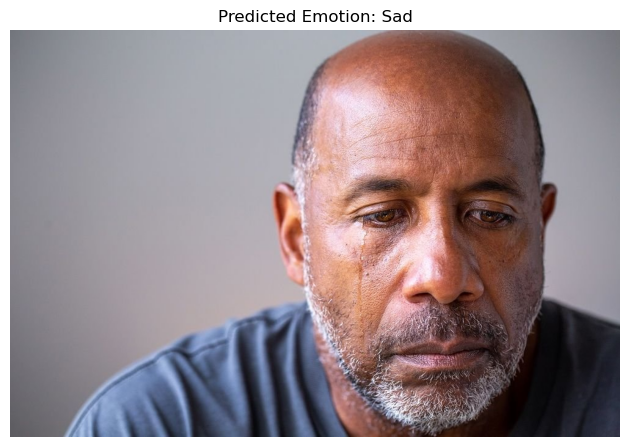

1/1 [==============================] - 0s 36ms/step


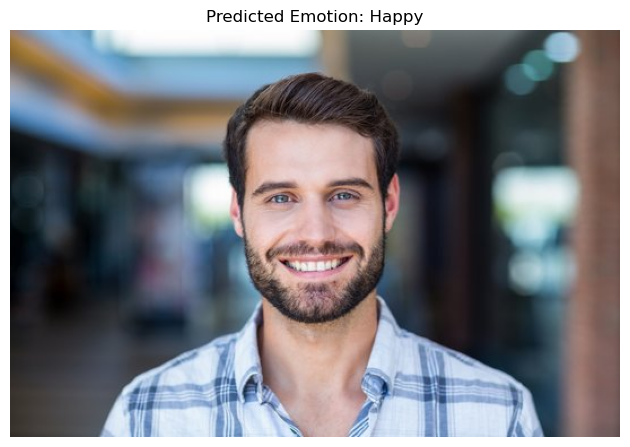

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("multi_input_emotion_model.h5")

# Emotion categories
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def preprocess_image(image_path):
    # Load original image for display
    original_img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    # Resize and normalize for model
    img_resized = cv2.resize(gray_img, (48, 48))
    img_normalized = img_resized.astype('float32') / 255.0
    img_input = np.expand_dims(img_normalized, axis=-1)
    img_input = np.expand_dims(img_input, axis=0)  # Shape: (1, 48, 48, 1)

    return img_input, original_img  # return original for display

def dummy_structured_input():
    return np.zeros((1, 139), dtype='float32')

def predict_emotion(image_path):
    img_input, display_img = preprocess_image(image_path)
    struct_input = dummy_structured_input()

    prediction = model.predict([img_input, struct_input])
    predicted_label = emotion_labels[np.argmax(prediction)]

    # Show original image with prediction
    display_img_rgb = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
    plt.imshow(display_img_rgb)
    plt.title(f"Predicted Emotion: {predicted_label}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
predict_emotion("SAD.jpg")
predict_emotion("Happy.jpg")